# 🎮 GameRx | Metadata Cleaning & Inspection  

📂 **Input:** `01_metadata_cleaning.csv`  

This notebook focuses on cleaning and shaping game genres so they connect smoothly with the review data later.

### Goals  
- Load the cleaned metadata file  
- Look through the `Genres` column  
- Split genres into readable pieces  
- Create `primary_genre` and `genre_count`  
- Get the dataset ready for merging with Steam reviews  

By the end, the metadata will be **genre-ready** and aligned with the cleaned review dataset.

### Table of Contents

1. [Import Libraries](#1-import-libraries)  
2. [Load Cleaned Metadata](#2-load-cleaned-metadata)  
3. [Check Required Columns + Genre Column Detection](#3-check-required-columns--genre-column-detection)  
4. [Split & Clean Genre Tags](#4-split--clean-genre-tags)  
5. [Value Counts & Top Genres](#5-value-counts--top-genres)  
6. [Feature Engineering: primary_genre + genre_count](#6-feature-engineering-primary_genre--genre_count)  
7. [Export Final Genre‑Ready Metadata](#7-export-final-genre‑ready-metadata)
8. [Insights & Next Steps](#8-insights-&-next-steps)

---

## 1. Import Libraries

Load the core libraries I’ll need for this notebook:
- **pandas** for data handling
- **numpy** for math operations
- **matplotlib / seaborn** for quick visuals
- **Pathlib** for safe file paths

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# File paths
from pathlib import Path

# Display settings for cleaner tables
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

---

## 2. Load Cleaned Metadata

Here I’m loading the cleaned Steam metadata file:  
`01_metadata_cleaning.csv`

Quick checks:
- Look at the shape  
- Preview a few rows  
- Confirm all key columns are present  

Then I can move on.

In [2]:
import pandas as pd
from pathlib import Path

# Use the full absolute path to the cleaned metadata file
META_PATH = Path(r"D:\YVC\YVC Portfolio Implementation\Data Analytics Projects\GameRx Your Digital Dose\02 Data\cleaned\01_games_metadata_cleaned.csv")

def load_csv(path: Path):
    if not path.exists():
        raise FileNotFoundError(f"Could not find file at: {path.resolve()}")
    df = pd.read_csv(path, low_memory=False)
    print(f"✔ Loaded: {path.name} | shape = {df.shape}")
    return df

# Load it
meta_df = load_csv(META_PATH)

# Preview
display(meta_df.head(3))

✔ Loaded: 01_games_metadata_cleaned.csv | shape = (105008, 19)


,AppID,Name,Release date,About the game,Languages,Metacritic score,User score,Positive,Negative,Recommendations,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags
0,20200,Galactic Bowling,10/21/2008,Galactic Bowling is an exaggerated and stylize...,['English'],0,0,6,11,30,0,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling"
1,655370,Train Bandit,10/12/2017,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",0,0,53,5,12,0,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,1732930,Jolt Project,11/17/2021,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",0,0,0,0,0,0,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN


---

## 3. Check Required Columns + Genre Column Detection

Here I’m confirming that the file has the key columns I need:

- `AppID`  
- `Name`  
- `Genres`

This step also checks if the genre column has a different name, just in case.

In [3]:
# Verify required columns
required = ["AppID", "Name"]
missing = [col for col in required if col not in meta_df.columns]
if missing:
    raise ValueError(f"Missing required column(s): {missing}")
else:
    print("✔ Required columns are present.")

# Step 2: Detect genre column (just in case it's labeled differently)
genre_col = None
for cand in ["Genres", "genres", "Tags", "tags", "Genre", "genre"]:
    if cand in meta_df.columns:
        genre_col = cand
        break

print("🎯 Detected genre column:", genre_col)

if genre_col is None:
    raise ValueError("❌ No genre column found. Expected one of: 'Genres', 'Tags', etc.")

# Step 3: Check how many unique games we have
n_games = meta_df["Name"].nunique()
print("🎮 Unique game titles:", n_games)

# Step 4: Peek at genre values
display(meta_df[[genre_col]].head(10))

✔ Required columns are present.
🎯 Detected genre column: Genres
🎮 Unique game titles: 103913


,Genres
0,"Casual,Indie,Sports"
1,"Action,Indie"
2,"Action,Adventure,Indie,Strategy"
3,"Adventure,Casual,Indie"
4,"Adventure,Indie"
5,"Adventure,Casual,Free to Play,Massively Multip..."
6,"Indie,Strategy"
7,Casual
8,"Adventure,RPG,Simulation,Strategy"
9,"Action,Adventure,Indie"


### 🔍 Results: Column Check & Genre Detection

- Required columns are present  
- Genre column found as `Genres`  
- **103,913 unique games**  
- Genres appear as comma-separated strings  

Ready to move into the **genre parsing** step.

---

## 4. Split & Clean Genre Tags

The `Genres` column stores all genres in one string (like `"Action, Indie"`).

#### What I’m doing
- Split by commas  
- Clean the text  
- Save the result in a new column: `genre_list`

#### Why it matters
This gives each game a clear list of genres I can count, filter, and use for later analysis.

In [4]:
# Convert the comma-separated string to a list of genres
meta_df["genre_list"] = (
    meta_df[genre_col]
    .fillna("")  # handle any NaNs
    .apply(lambda x: [tag.strip() for tag in x.split(",") if tag.strip()])
)

# Preview the new column
display(meta_df[[genre_col, "genre_list"]].head(10))

# Check for any empty genre lists
empty_genres = meta_df[meta_df["genre_list"].str.len() == 0]
print(f"Games with no genre tags: {len(empty_genres)}")

,Genres,genre_list
0,"Casual,Indie,Sports","[Casual, Indie, Sports]"
1,"Action,Indie","[Action, Indie]"
2,"Action,Adventure,Indie,Strategy","[Action, Adventure, Indie, Strategy]"
3,"Adventure,Casual,Indie","[Adventure, Casual, Indie]"
4,"Adventure,Indie","[Adventure, Indie]"
5,"Adventure,Casual,Free to Play,Massively Multip...","[Adventure, Casual, Free to Play, Massively Mu..."
6,"Indie,Strategy","[Indie, Strategy]"
7,Casual,[Casual]
8,"Adventure,RPG,Simulation,Strategy","[Adventure, RPG, Simulation, Strategy]"
9,"Action,Adventure,Indie","[Action, Adventure, Indie]"


Games with no genre tags: 0


#### 🔍 Results: Genre Splitting

- `Genres` column split successfully  
- `genre_list` now holds a clean list of genres for each game  
- No empty tags found  

This format is ready for counting, analysis, and future visuals.

---

## 5. Value Counts & Top Genres

Each game has a clean list of genres, so it’s time to check which ones appear most often.

#### Goal
Identify the dominant genres.  
This will guide grouping, filtering, and later analysis. 

In [5]:
from collections import Counter

# Flatten the genre lists and count each genre
all_genres = [genre for sublist in meta_df["genre_list"] for genre in sublist]
genre_counts = pd.Series(Counter(all_genres)).sort_values(ascending=False)

# Preview top genres
print("Top 15 Genres:")
display(genre_counts.head(15))

Top 15 Genres:


Indie                    73092
Casual                   45113
Action                   42652
Adventure                40749
Simulation               21430
Strategy                 20217
RPG                      19091
Early Access             13937
Free to Play              7919
Sports                    4732
Racing                    3917
Massively Multiplayer     2706
Free To Play              2169
Utilities                 1013
Design & Illustration      582
dtype: int64

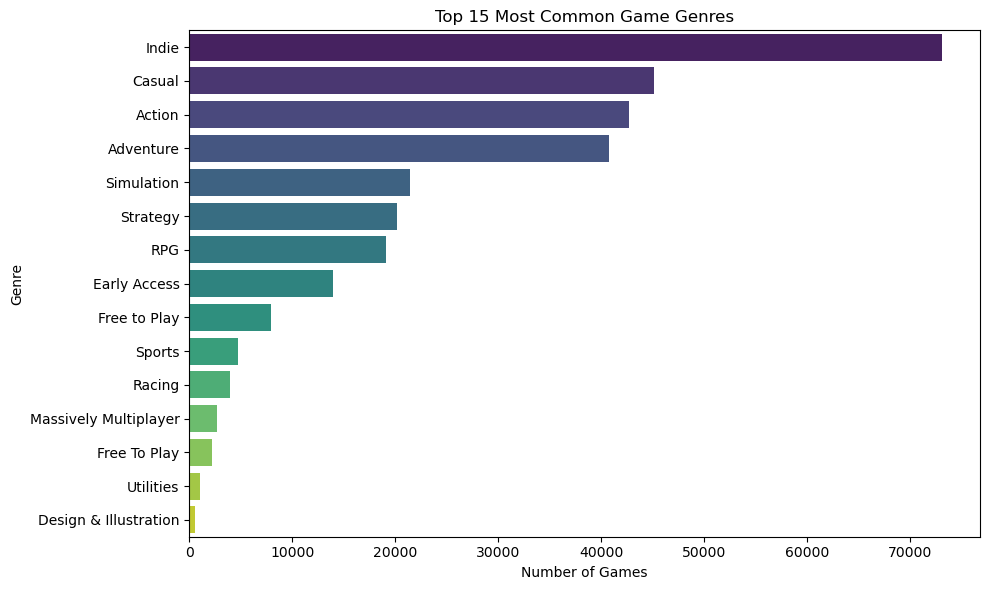

In [6]:
# Plot the top genres (cleaned version to avoid deprecation warning)
plt.figure(figsize=(10, 6))
sns.barplot(
    x=genre_counts.head(15).values,
    y=genre_counts.head(15).index,
    hue=genre_counts.head(15).index,  # set hue to match y
    palette="viridis",
    dodge=False,
    legend=False  # suppress the legend since y already shows genre names
)
plt.title("Top 15 Most Common Game Genres")
plt.xlabel("Number of Games")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

### 🔍 Results: Genre Counts

- **Indie** is the top genre  
- Followed by **Casual**, **Action**, and **Adventure**  
- **Simulation**, **Strategy**, and **RPG** also show up often  
- I now have a clear ranked list of all genres  

This gives me a solid base for filtering, grouping, and future modeling work. 

---

## 6. Feature Engineering: `primary_genre` + `genre_count`

Adding two simple features to make genre analysis easier.

#### New Features
- `primary_genre` → first genre in the list  
- `genre_count` → how many genres each game has

These help with grouping games and exploring genre variety.  

In [7]:
# Add primary genre (first in the list, if it exists)
meta_df["primary_genre"] = meta_df["genre_list"].apply(lambda x: x[0] if len(x) > 0 else None)

# Add genre count
meta_df["genre_count"] = meta_df["genre_list"].apply(len)

# Preview the new features
display(meta_df[["genre_list", "primary_genre", "genre_count"]].head(10))

# Check for any null primary genres
null_primaries = meta_df["primary_genre"].isna().sum()
print(f"Games with no primary genre: {null_primaries}")

,genre_list,primary_genre,genre_count
0,"[Casual, Indie, Sports]",Casual,3
1,"[Action, Indie]",Action,2
2,"[Action, Adventure, Indie, Strategy]",Action,4
3,"[Adventure, Casual, Indie]",Adventure,3
4,"[Adventure, Indie]",Adventure,2
5,"[Adventure, Casual, Free to Play, Massively Mu...",Adventure,6
6,"[Indie, Strategy]",Indie,2
7,[Casual],Casual,1
8,"[Adventure, RPG, Simulation, Strategy]",Adventure,4
9,"[Action, Adventure, Indie]",Action,3


Games with no primary genre: 0


#### 🔍 Results: Feature Engineering

- `primary_genre` added  
- `genre_count` added  
- No missing values in `primary_genre`

These features make sorting, grouping, and filtering much easier later on.

---

## 7. Export Final Genre-Ready Metadata  

The dataset now includes clean genre features:  
`genre_list`, `primary_genre`, and `genre_count`.  

#### 💾 Save Details  
Exported for future analysis and merging as:  
`02_games_metadata_genre_ready.csv`  

In [8]:
# Define output path
from pathlib import Path

EXPORT_PATH = Path(r"D:\YVC\YVC Portfolio Implementation\Data Analytics Projects\GameRx Your Digital Dose\02 Data\cleaned\02_games_metadata_genre_ready.csv")

# Save as CSV
meta_df.to_csv(EXPORT_PATH, index=False)
print(f"✅ File exported: {EXPORT_PATH.name}")

✅ File exported: 02_games_metadata_genre_ready.csv


---

## 8. Insights & Next Steps

Genre parsing and feature engineering are complete.  
The dataset is now **genre-ready** and saved as `02_games_metadata_genre_ready.csv`.

#### ➡️ Next 
**`03_genre_merge_cleaning.ipynb`**  
Here we’ll merge this metadata with the cleaned Steam reviews to link player emotions with game genres.